# <font color='blue'> <b> <center> EDA AND QUICK PROTOTYPING </center> </b> </font>

### 📑 <font color='blue'> Table of Contents </font>
1. [Introduction](#1)
2. [Setup](#2)
3. [Loading and inspecting data](#3)
4. [Models](#4) <br>
    4.1. [Baseline](#4.1) <br>
    4.2. [Tree](#4.2) <br>
    4.3. [Random Forest](#4.3) <br>
    4.4. [Neural Network](#4.4)
5. [Annex](#annex) <br>
    A. [Class Imbalance](#A) <br>
    B. [Custom metric in Tuner](#B) <br>


<h1 style="text-align: center; color: darkblue;">EDA and Quick Prototyping</h1>
## <a id="1" style="color: darkred; text-decoration: none;">1. Introduction</a>

### <a id="4.1" style="color: darkorange; text-decoration: none;"> 4.1. Baseline </a>

## Dataset References

The Chest X-ray dataset used in this project is publicly available from the NIH Clinical Center:

- **Dataset**: NIH Chest X-ray dataset (ChestX-ray14)  
  Download and licensing information: https://nihcc.app.box.com/v/ChestXray-NIHCC

If you use this dataset in published work, please cite the following paper:

> Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, and Ronald M. Summers.  
> *ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases*,  
> IEEE CVPR 2017. doi:10.1109/CVPR.2017.369

Dataset attribution requires acknowledgment of the NIH Clinical Center as the data provider.  

## 1. Introduction


# Exploratory Data Analysis & Quick Prototyping  
## NIH Chest X-Ray Multi-Label Classification

This notebook performs **Exploratory Data Analysis (EDA)** and rapid prototyping for the NIH Chest X-ray dataset, released by the National Institutes of Health (NIH).

The task is formulated as a **multi-label classification problem**:  
Each chest X-ray image may contain **zero, one, or multiple pathologies** simultaneously.  
The model must output **14 independent binary predictions**, indicating the presence or absence of each pathology.

---

## Project Goal

The objective is to build a baseline system capable of predicting the following 14 thoracic diseases:

- Atelectasis  
- Cardiomegaly  
- Effusion  
- Infiltration  
- Mass  
- Nodule  
- Pneumonia  
- Pneumothorax  
- Consolidation  
- Edema  
- Emphysema  
- Fibrosis  
- Pleural Thickening  
- Hernia  

Given computational constraints, this notebook uses **a subset of the dataset** to:

1. Understand label distribution and imbalance  
2. Inspect co-occurrence patterns between pathologies  
3. Analyze image characteristics (resolution, intensity distribution)  
4. Build a minimal but structured training pipeline  
5. Train a lightweight baseline model for quick iteration  

---

## Scope & Philosophy

This notebook prioritizes:

- Clear data understanding before modeling  
- Proper handling of **class imbalance**, which is severe in this dataset  
- Fast iteration over architectural complexity  
- Clean experimentation structure suitable for scaling later  

The goal is **not state-of-the-art performance**, but rather:

- A reliable experimental baseline  
- A reproducible setup  
- Insight into dataset challenges before committing to larger-scale training  







## SETUP

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

2026-02-25 17:54:02.674064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# Data paths
DATA_ROOT = "../data/nih/"

IMAGE_DIR = DATA_ROOT+"images-small/"
TRAIN_PATH = DATA_ROOT+"train-small.csv"
VALID_PATH = DATA_ROOT+"valid-small.csv"
TEST_PATH = DATA_ROOT+"test.csv"


# labels
labels = ['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Helper functions

In [13]:
# plots

def plot_images(df, img_dir=IMAGE_DIR):
    # Extract numpy values from Image column in data frame
    images = df['Image'].values

    # Extract 9 random images from it
    random_images = [np.random.choice(images) for i in range(9)]

    print('Display Random Images')

    # Adjust the size of your images
    plt.figure(figsize=(20,10))

    # Iterate and plot random images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(os.path.join(img_dir, random_images[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()    


def plot_image_detail(sample_img, img_dir=IMAGE_DIR):
    raw_image = plt.imread(os.path.join(img_dir, sample_img))
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')
    print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
    print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
    print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")
    
    
    
def plot_pixel_distribution(sample_img, img_dir=IMAGE_DIR):
    raw_image = plt.imread(os.path.join(img_dir, sample_img))
    # Plot a histogram of the distribution of the pixels
    sns.displot(raw_image.ravel(), 
                 label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
    plt.legend(loc='upper center')
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    
    
def plot_preprocessed_image(generator, iden=0):
    sns.set_style("white")
    generated_image, label = generator.__getitem__(iden)
    plt.imshow(generated_image[0], cmap='gray')
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')
    print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
    print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
    print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")




def plot_pixel_intensity_distribution_comparison(sample_img, generator, img_dir=IMAGE_DIR, iden=0):
    
    raw_image = plt.imread(os.path.join(img_dir, sample_img))
    generated_image, label = generator.__getitem__(iden)

    # Include a histogram of the distribution of the pixels
    sns.set()
    plt.figure(figsize=(10, 7))

    # Plot histogram for original iamge
    sns.distplot(raw_image.ravel(), 
                 label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
                 f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
                 color='blue', 
                 kde=False)

    # Plot histogram for generated image
    sns.distplot(generated_image[0].ravel(), 
                 label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
                 f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
                 color='red', 
                 kde=False)

    # Place legends
    plt.legend()
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixel')

    
def plot_class_label_distribution(labels, pos_values, neg_values):
    data = pd.DataFrame({
        "Class": labels,
        "Label": "Positive",
        "Value": pos_values
    })

    neg_df = pd.DataFrame({
        "Class": labels,
        "Label": "Negative",
        "Value": neg_values
    })

    data = pd.concat([data, neg_df], ignore_index=True)

    #plt.figure(figsize=(10, 6))
    sns.barplot(x="Class", y="Value", hue="Label", data=data)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


### Load data and visualization

In [14]:
def load_data():
    train_df = pd.read_csv(TRAIN_PATH)
    valid_df = pd.read_csv(VALID_PATH)
    test_df = pd.read_csv(TEST_PATH)
    return train_df, valid_df, test_df

In [15]:
train_df, val_df, test_df = load_data()

In [16]:
train_df.shape, val_df.shape, test_df.shape

((1000, 16), (200, 16), (420, 16))

In [17]:
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

In [17]:
for col, count in train_df[labels].sum().items():
    print(f"The class {col} has {count} samples")
    
    
# a plot here -> before it counts positives

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


### Visualize images

Display Random Images


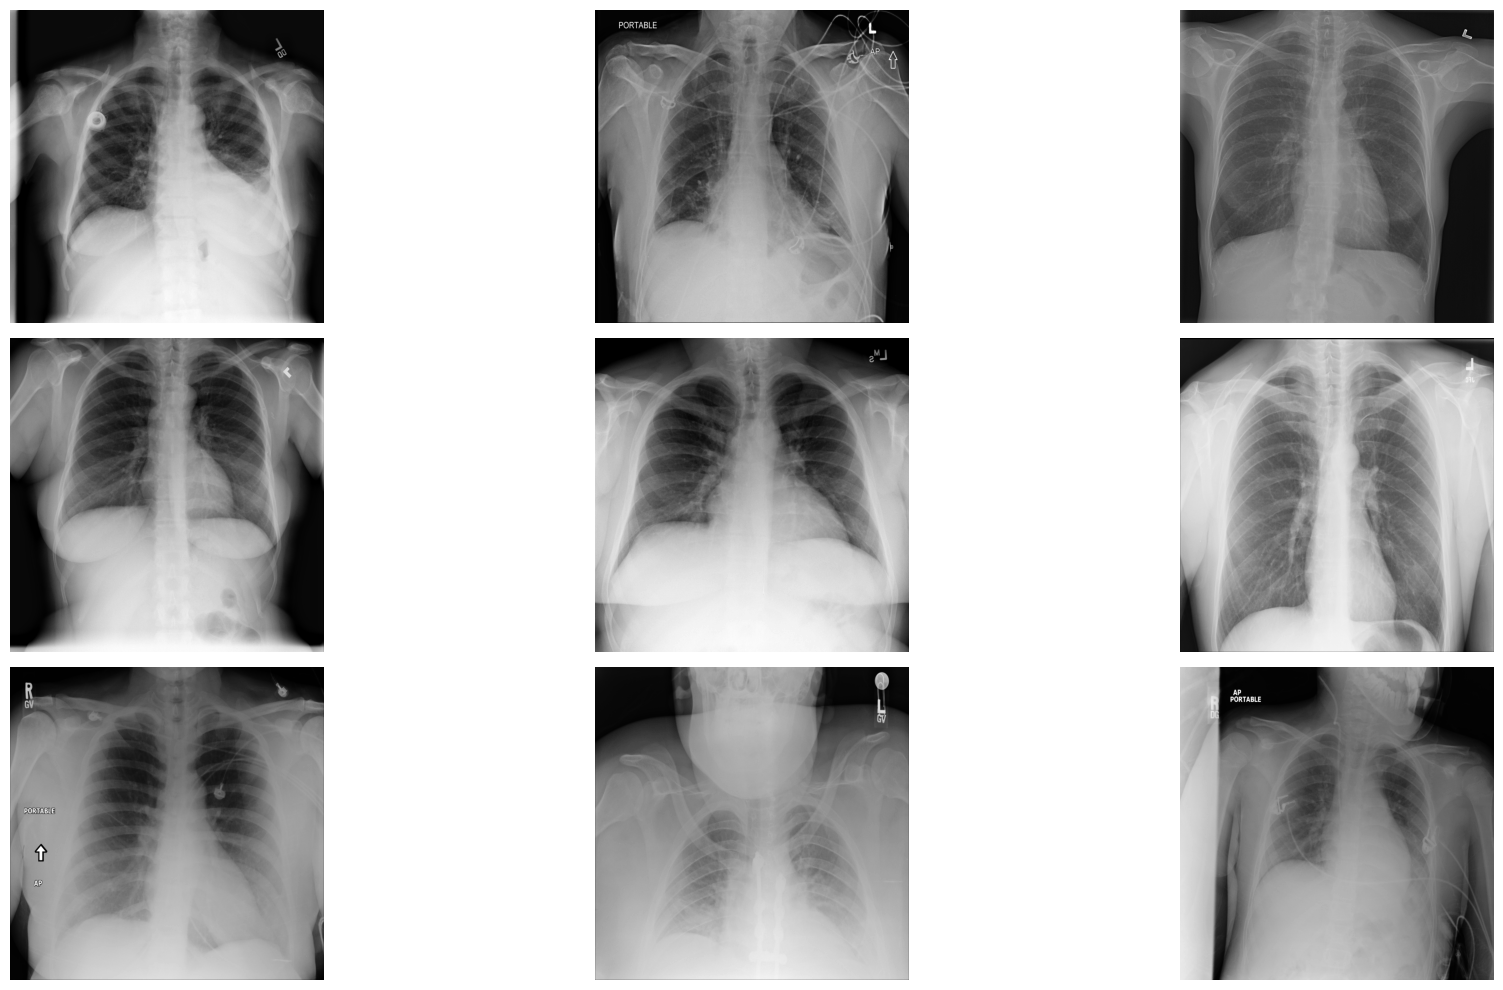

In [21]:
plot_images(train_df)    

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


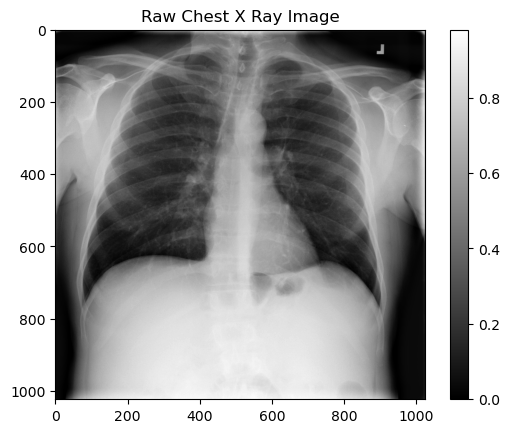

In [22]:
plot_image_detail(train_df.Image[0])    

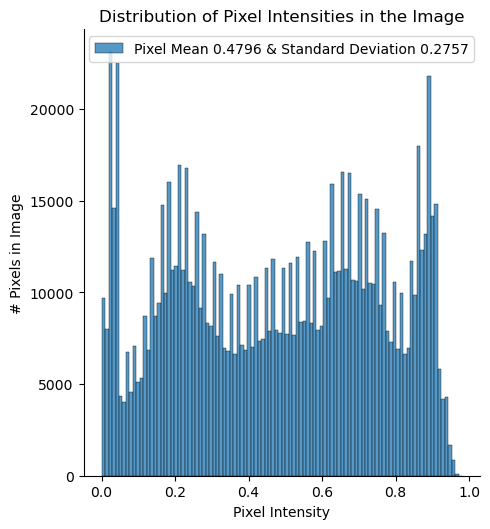

In [23]:
plot_pixel_distribution(train_df.Image[0])

## Data generators

In [24]:
def get_generator(df, image_dir, x_col, y_cols, shuffle, batch_size=32, 
                        seed=1, target_w = 320, target_h = 320, preprocess_fn=None):
    # normalize images
    image_generator = ImageDataGenerator(
        rescale=1./255
    )
    
    if preprocess_fn is None:
        image_generator = ImageDataGenerator(
            rescale=1./255
        )
    else:
        image_generator = ImageDataGenerator(preprocessing_function=preprocess_fn)
    
    # flow from directory with specified batch size and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [25]:
train_generator = get_generator(train_df, IMAGE_DIR, "Image", labels, True, preprocess_fn=None)

Found 1000 validated image filenames.


In [26]:
for x,y in train_generator:
    print(x.shape) # batch_size, width, height, channels
    print(y.shape) # batch size, num_outputs
    break

(32, 320, 320, 3)
(32, 14)


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.4781 and the standard deviation is 0.2370


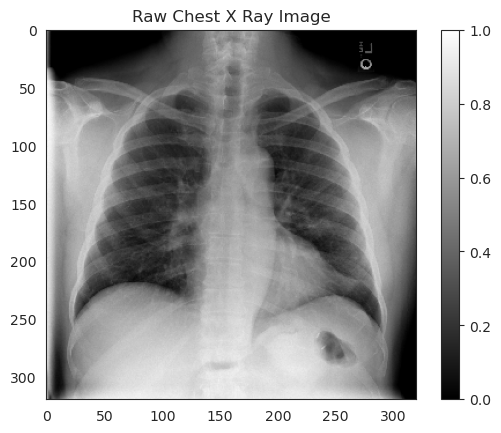

In [28]:
plot_preprocessed_image(train_generator) # cnn case; do it for densent and effientnet too

/tmp/ipykernel_398334/3294321101.py:71: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
/tmp/ipykernel_398334/3294321101.py:78: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


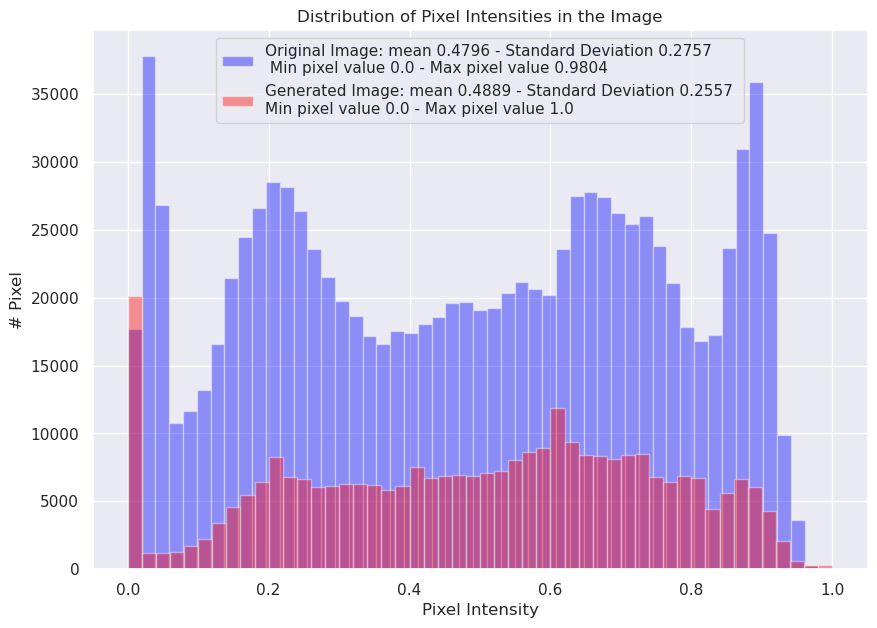

In [29]:
plot_pixel_intensity_distribution_comparison(train_df.Image[0], train_generator)    

## Handling class imbalance


### Positional weights

In [30]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [31]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.106, 0.02 , 0.033, 0.016, 0.128, 0.013, 0.014, 0.002, 0.175,
       0.045, 0.054, 0.021, 0.01 , 0.038])

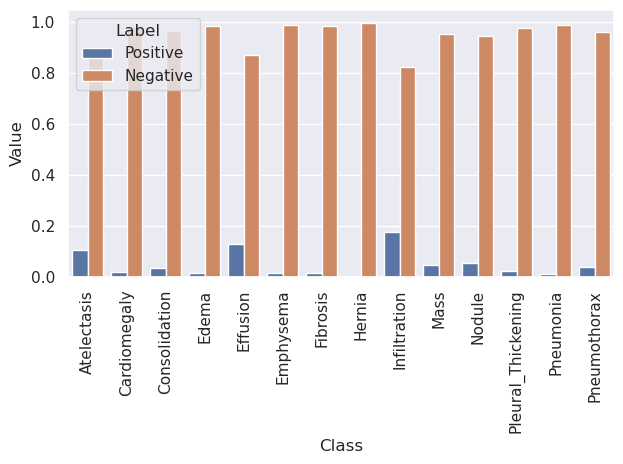

In [32]:
plot_class_label_distribution(labels, freq_pos, freq_neg)

The dataset exhibits severe class imbalance, with all pathologies appearing in a small fraction of samples. This imbalance can bias the model toward majority classes and degrade recall for rare diseases.

To mitigate this issue, the models will be trained using a **weighted binary cross-entropy loss with logits**, where class weights are derived from empirical label frequencies in the training subset.

In [33]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

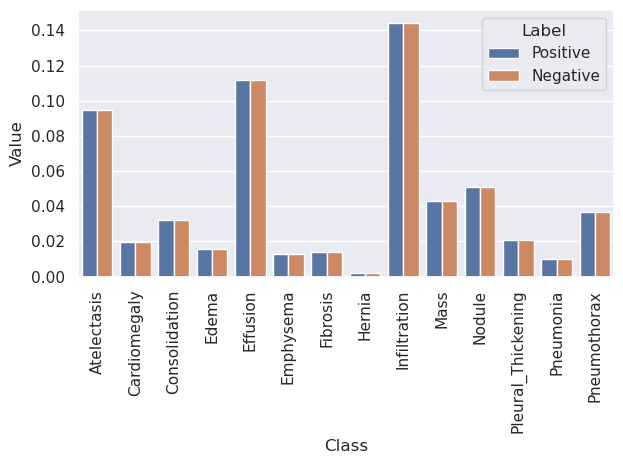

In [34]:
plot_class_label_distribution(labels, pos_contribution, neg_contribution)

### Weighted loss

In [40]:
def weighted_bce_loss(pos_weights):
    def loss(y_true, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels=y_true,
            logits=logits,
            pos_weight=pos_weights
        )
        return tf.reduce_mean(loss)
    return loss

## Quick prototyping


### Model 1: Baseline (Simple CNN)

In [9]:
# random subset for faster traiuning

"""
train_df = pd.read_csv(TRAIN_PATH)

subset_frac = 0.2  # 20% of data
train_df = train_df.sample(frac=subset_frac, random_state=42).reset_index(drop=True)

"""

'\ntrain_df = pd.read_csv(TRAIN_PATH)\n\nsubset_frac = 0.2  # 20% of data\ntrain_df = train_df.sample(frac=subset_frac, random_state=42).reset_index(drop=True)\n\n'

In [36]:
# Generators
train_generator = get_generator(train_df, IMAGE_DIR, "Image", labels, True, preprocess_fn=None)
val_generator = get_generator(val_df, IMAGE_DIR, "Image", labels, True, preprocess_fn=None)

Found 1000 validated image filenames.
Found 200 validated image filenames.


In [37]:
# Model
def build_simple_cnn(input_shape=(320, 320, 3), num_classes=14):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes)(x)  # LOGITS (no sigmoid)

    model = models.Model(inputs, outputs, name="simple_cnn_baseline")
    return model

model = build_simple_cnn()

2026-02-25 19:00:15.027321: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [38]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=weighted_bce_loss(pos_weights),
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="auroc"),
        tf.keras.metrics.AUC(curve="PR", multi_label=True, name="auprc"),
    ]
)

model.summary()


Model: "simple_cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 320, 320, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320, 320, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,462 (439.30 KB)

 Trainable params: 112,014 (437.55 KB)

 Non-trainable params: 448 (1.75 KB)

In [39]:
# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    steps_per_epoch=100,
    validation_steps=25
)

2026-02-25 19:00:20.084355: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 419430400 exceeds 10% of free system memory.
2026-02-25 19:00:20.412609: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 419430400 exceeds 10% of free system memory.
2026-02-25 19:00:20.650913: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 419430400 exceeds 10% of free system memory.
2026-02-25 19:00:23.139190: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 419430400 exceeds 10% of free system memory.
2026-02-25 19:00:23.637991: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 419430400 exceeds 10% of free system memory.


  3/100 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - auprc: 0.0517 - auroc: 0.3825 - loss: 0.7365

KeyboardInterrupt: 

In [ ]:
# Making preds
x_batch, y_batch = next(train_generator)

print(x_batch.shape)  # (batch_size, H, W, 3)
print(y_batch.shape)  # (batch_size, 14)


In [99]:
logits = model.predict(x_batch)        # shape (N, 14)
probs = tf.sigmoid(logits).numpy()


print(f"Logits: {logits[0]}\n") # for the first sample of the batch
print(f"Probs: {probs[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
Logits: [ 0.00826378 -0.10225689 -0.14827302 -0.15922876 -0.10068054 -0.12930596
 -0.12117103 -0.18666957 -0.16441135 -0.08695977  0.05980612 -0.09066207
 -0.01502086 -0.07858104]

Probs: [0.50206596 0.474458   0.4629995  0.4602767  0.47485104 0.46771842
 0.46974424 0.4534676  0.4589895  0.47827378 0.514947   0.47734997
 0.49624485 0.48036486]


In [101]:
probs.shape

(32, 14)

**Note**

Each output neuron models the probability of the positive class for a given pathology.

Why is the output shape `(batch_size, 14)`?

Because this is a **multi-label binary classification** problem.

For each image, the model independently predicts:

```
P(class_i = 1 | image), for i = 1, ..., 14
```


Therefore:

- 14 diseases  
- 1 logit (or probability after sigmoid) per disease  

Output shape → `(batch_size, 14)`

There is no second column for the negative class because:

```
P(class_i = 0 | image) = 1 − P(class_i = 1 | image)
```

In [63]:
probs[0]

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([0.3559394 , 0.3676456 , 0.27630204, 0.27163708, 0.43815774,
       0.417968  , 0.39453155, 0.308069  , 0.5256638 , 0.43184596,
       0.36954126, 0.47335887, 0.3931201 , 0.40068996], dtype=float32)>

## Efficient Net

In [102]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications import EfficientNetB0

In [104]:
# generators
train_generator = get_generator(train_df, IMAGE_DIR, "Image", labels, True, 
                                preprocess_fn=preprocess_input_efficientnet)
val_generator = get_generator(val_df, IMAGE_DIR, "Image", labels, False, 
                              preprocess_fn=preprocess_input_efficientnet)

Found 1000 validated image filenames.
Found 200 validated image filenames.


In [106]:
# Model
def build_efficientnet(
    input_shape=(320, 320, 3),
    num_classes=14,
    train_backbone=False
):
    backbone = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    backbone.trainable = train_backbone

    inputs = layers.Input(shape=input_shape)
    x = inputs

    x = backbone(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes)(x)  # LOGITS

    model = models.Model(inputs, outputs, name="efficientnet_b0")
    return model

model = build_efficientnet(train_backbone=False)

In [107]:
# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=weighted_bce_loss(pos_weights),
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="auroc"),
        tf.keras.metrics.AUC(curve="PR", multi_label=True, name="auprc"),
    ]
)

model.summary()


Model: "efficientnet_b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 10, 10, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,225 (16.73 MB)

 Trainable params: 334,094 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [108]:
# feature extractor
history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    steps_per_epoch=100,
    validation_steps=25
)


 32/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - auprc: 0.0604 - auroc: 0.4941 - loss: 0.8549

/home/marcos/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 893ms/step - auprc: 0.0554 - auroc: 0.5048 - loss: 0.7888 - val_auprc: 0.0529 - val_auroc: 0.5197 - val_loss: 0.6148


In [109]:
# unfreeze and fine-tune
backbone = model.get_layer("efficientnetb0")

for layer in backbone.layers[-30:]:
    layer.trainable = True

# re-compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=weighted_bce_loss(pos_weights),
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="auroc"),
        tf.keras.metrics.AUC(curve="PR", multi_label=True, name="auprc"),
    ]
)

model.summary()

Model: "efficientnet_b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 10, 10, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,225 (16.73 MB)

 Trainable params: 1,830,254 (6.98 MB)

 Non-trainable params: 2,555,971 (9.75 MB)

Note the increase in the trainable params.

In [110]:
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    steps_per_epoch=100,
    validation_steps=25
)


Epoch 1/2
  1/100 ━━━━━━━━━━━━━━━━━━━━ 22:45 14s/step - auprc: 0.0473 - auroc: 0.2372 - loss: 0.6943

KeyboardInterrupt: 

In [75]:
history_ft.history

{'auprc': [0.053029753267765045, 0.05035373941063881],
 'auroc': [0.5090724229812622, 0.490608274936676],
 'loss': [0.610129714012146, 0.5801177024841309],
 'val_auprc': [0.10248732566833496, 0.09359478205442429],
 'val_auroc': [0.5854498744010925, 0.5852710008621216],
 'val_loss': [0.49783095717430115, 0.4835553467273712]}

## Dense121

In [42]:
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [43]:
# generators
train_generator = get_generator(train_df, IMAGE_DIR, "Image", labels, True, batch_size=4,
                                preprocess_fn=preprocess_input_densenet)
val_generator = get_generator(val_df, IMAGE_DIR, "Image", labels, False, batch_size=4,
                              preprocess_fn=preprocess_input_densenet)

Found 1000 validated image filenames.
Found 200 validated image filenames.


In [56]:
def build_compile_densenet():
    # create the base model
    base_model = DenseNet121(include_top=False, weights="imagenet", name="backbone")

    # freeze backbone
    base_model.trainable = False

    x = base_model.output

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = Dense(14, activation=None)(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss=weighted_bce_loss(pos_weights))

    return model



def build_compile_densenet(
    input_shape=(320, 320, 3),
    num_classes=14,
    train_backbone=False
):

    backbone_base = DenseNet121(
        include_top=False,
        weights="imagenet"
    )

    backbone_base.trainable = False

    # Wrap backbone with stable name
    backbone = tf.keras.Model(
        inputs=backbone_base.input,
        outputs=backbone_base.output,
        name="backbone"
    )

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = backbone(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=None)(x)

    model = tf.keras.Model(inputs, outputs, name="classifier")

    model.compile(
        optimizer="adam",
        loss=weighted_bce_loss(pos_weights)
    )

    return model



model = build_compile_densenet()
#model.summary()

In [57]:
#----------Feature extraction-----------#
history = model.fit(train_generator, 
      validation_data=val_generator,
      steps_per_epoch=100, 
      validation_steps=25,
      epochs = 1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 681ms/step - loss: 0.1866 - val_loss: 0.1499


In [58]:
#---------Fine tuning------------------#

# unfreeze and fine-tune
backbone = model.get_layer("backbone")

for layer in backbone.layers[-30:]:
    layer.trainable = True

# re-compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), # lower LR
    loss=weighted_bce_loss(pos_weights),
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="auroc"),
        tf.keras.metrics.AUC(curve="PR", multi_label=True, name="auprc"),
    ]
)

model.summary()

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ (None, 10, 10, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 655,758 (2.50 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

In [59]:
#------Fit--------------#

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    steps_per_epoch=100,
    validation_steps=25
)


Epoch 1/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 640ms/step - auprc: 0.0509 - auroc: 0.4643 - loss: 0.1780 - val_auprc: 0.0450 - val_auroc: 0.3929 - val_loss: 0.1461
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 599ms/step - auprc: 0.0495 - auroc: 0.4643 - loss: 0.1651 - val_auprc: 0.0450 - val_auroc: 0.3929 - val_loss: 0.1455
